In [1]:
from jax_unirep import get_reps

sequence = "ASDFGHJKL"

# h_avg is the canonical "reps"
h_avg, h_final, c_final = get_reps(sequence)

/home/bli/.conda/envs/ag/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
sequences = ["ASDF", "YJKAL", "QQLAMEHALQP"]

# h_avg is the canonical "reps"
h_avg, h_final, c_final= get_reps(sequences)
h_final.shape

(3, 1900)

In [3]:
help(get_reps)

Help on function get_reps in module jax_unirep.featurize:

get_reps(seqs: Union[str, Iterable[str]], params: Optional[Dict] = None, mlstm_size: Optional[str] = 1900) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Get reps of proteins.
    
    This function generates representations of protein sequences
    using the mLSTM model from the
    [UniRep paper](https://github.com/churchlab/UniRep).
    
    Each element of the output 3-tuple is a `np.array`
    of shape (n_input_sequences, mlstm_size):
    
    - `h_avg`: Average hidden state of the mLSTM over the whole sequence.
    - `h_final`: Final hidden state of the mLSTM
    - `c_final`: Final cell state of the mLSTM
    
    You should not use this function
    if you want to do further JAX-based computations
    on the output vectors!
    In that case, the `DeviceArray` futures returned by `mLSTM`
    should be passed directly into the next step
    instead of converting them to `np.array`s.
    The conversion to `np.arr

In [4]:
import os
import pandas as pd
import numpy as np
DATA_PATH = "../dataset/dataset2.0/" # Path to data
EMBED_PATH =DATA_PATH+'/UniRep_embed/'

import tqdm
def extract_embed(data_file):    
    
    input_data  =DATA_PATH+data_file
    output_dir = EMBED_PATH
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_df = pd.read_csv(input_data)

    embeds,_,_ = get_reps(list(data_df['seq']))
    ids = np.array(list(data_df['id']))
    
    np.save(output_dir+'{}_embeds.npy'.format(data_file.split('.')[0]), embeds)
    np.save(output_dir+'{}_ids.npy'.format(data_file.split('.')[0]), np.array(ids))
    print('Extract UniRep embeddings for {}, save in {}'.format(input_data,output_dir))

In [5]:
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        print(file)
        extract_embed(file)

test_data1_2023-6-9_15_31.csv
Extract UniRep embeddings for ../dataset/dataset2.0/test_data1_2023-6-9_15_31.csv, save in ../dataset/dataset2.0//UniRep_embed/
test_data2_2023-6-9_15_31.csv
Extract UniRep embeddings for ../dataset/dataset2.0/test_data2_2023-6-9_15_31.csv, save in ../dataset/dataset2.0//UniRep_embed/
positive_train_422.csv
Extract UniRep embeddings for ../dataset/dataset2.0/positive_train_422.csv, save in ../dataset/dataset2.0//UniRep_embed/
negative_train_3307.csv
Extract UniRep embeddings for ../dataset/dataset2.0/negative_train_3307.csv, save in ../dataset/dataset2.0//UniRep_embed/


In [6]:

import os
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
def load_embed(csv_file):
    Embed_PATH = EMBED_PATH+csv_file.split('.')[0]+'_embeds.npy'
    data_df =  pd.read_csv(DATA_PATH+csv_file)
    ys = data_df['label']
    Xs = np.load(Embed_PATH)
    print('load{} T5 embedding from {}'.format(csv_file,Embed_PATH))
    print(len(ys))
    print(Xs.shape)
    return Xs,ys
Xs = []
ys = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        if file.endswith('llpsdb_d.csv'):continue
        x,y = load_embed(file)
        Xs.append(x)
        ys.append(y)
Xs = np.vstack((*Xs,))
ys = [y for sub in ys for y in sub]
print(len(ys))
print(Xs.shape)
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_pca = pca.fit_transform(Xs)

loadtest_data1_2023-6-9_15_31.csv T5 embedding from ../dataset/dataset2.0//UniRep_embed/test_data1_2023-6-9_15_31_embeds.npy
226
(226, 1900)
loadtest_data2_2023-6-9_15_31.csv T5 embedding from ../dataset/dataset2.0//UniRep_embed/test_data2_2023-6-9_15_31_embeds.npy
274
(274, 1900)
loadpositive_train_422.csv T5 embedding from ../dataset/dataset2.0//UniRep_embed/positive_train_422_embeds.npy
422
(422, 1900)
loadnegative_train_3307.csv T5 embedding from ../dataset/dataset2.0//UniRep_embed/negative_train_3307_embeds.npy
3307
(3307, 1900)
4229
(4229, 1900)


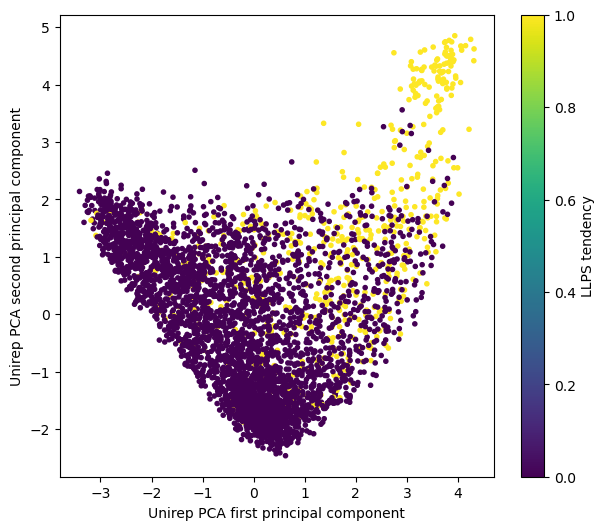

In [7]:
import matplotlib.pyplot as plt
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_pca[:,0], Xs_pca[:,1], c=ys, marker='.')
ax.set_xlabel('Unirep PCA first principal component')
ax.set_ylabel('Unirep PCA second principal component')
plt.colorbar(sc, label='LLPS tendency')